In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from supplemental_english import REGION_CODES, GOVERNMENT_CODES


In [2]:
train_df = pd.read_csv(r"C:\Users\user\Desktop\kaggle_project\train.csv")
test_df = pd.read_csv(r"C:\Users\user\Desktop\kaggle_project\test.csv")
sample_submission = pd.read_csv(r"C:\Users\user\Desktop\kaggle_project\sample_submission.csv")

In [3]:
train_df.info(),test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51635 non-null  int64 
 1   plate   51635 non-null  object
 2   date    51635 non-null  object
 3   price   51635 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7695 entries, 0 to 7694
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      7695 non-null   int64  
 1   plate   7695 non-null   object 
 2   date    7695 non-null   object 
 3   price   0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 240.6+ KB


(None, None)

In [4]:
train_df.isnull().sum(),test_df.isnull().sum()

(id       0
 plate    0
 date     0
 price    0
 dtype: int64,
 id          0
 plate       0
 date        0
 price    7695
 dtype: int64)

In [5]:
train_df.head,test_df.head

(<bound method NDFrame.head of           id      plate                 date    price
 0          1  X059CP797  2024-12-26 00:00:00    65000
 1          2  Y800MH790  2024-07-12 21:31:37   100000
 2          3   A212TX77  2024-04-18 00:00:00   290000
 3          4  P001AY199  2025-01-03 00:27:15   680000
 4          5  P001AY199  2025-01-10 09:32:41   750000
 ...      ...        ...                  ...      ...
 51630  51631  X023PP797  2025-01-29 00:00:00    70000
 51631  51632  M004KA161  2025-01-31 00:00:00  1600000
 51632  51633  E888EB199  2025-02-06 00:00:00   850000
 51633  51634   X023XK77  2024-04-24 11:30:07   150000
 51634  51635  K450OC797  2023-10-06 00:00:00    25000
 
 [51635 rows x 4 columns]>,
 <bound method NDFrame.head of          id      plate                 date  price
 0     51636  P700TT790  2025-01-27 00:00:00    NaN
 1     51637  M081TX797  2025-02-10 00:00:00    NaN
 2     51638  T333HX777  2025-02-11 00:00:00    NaN
 3     51639  H744BH977  2025-02-03 00:00:

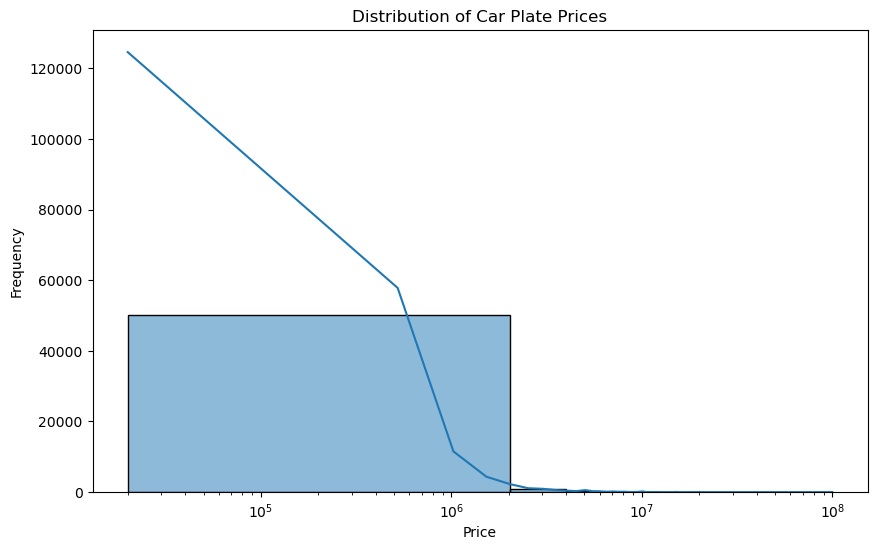

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['price'], bins=50, kde=True)
plt.title('Distribution of Car Plate Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xscale('log')  

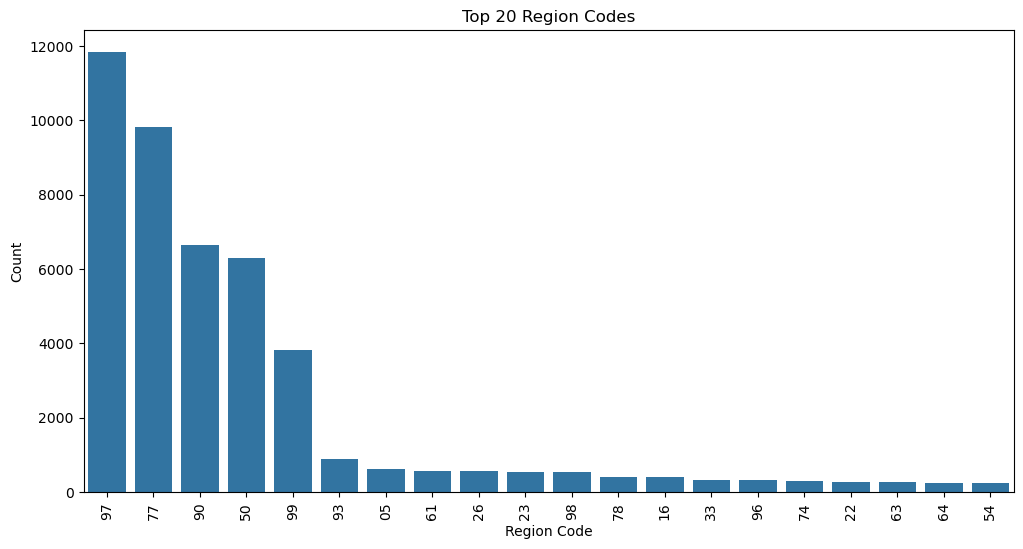

In [7]:
plt.figure(figsize=(12, 6))
region_counts = train_df['plate'].str[-2:].value_counts().head(20)
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title('Top 20 Region Codes')
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


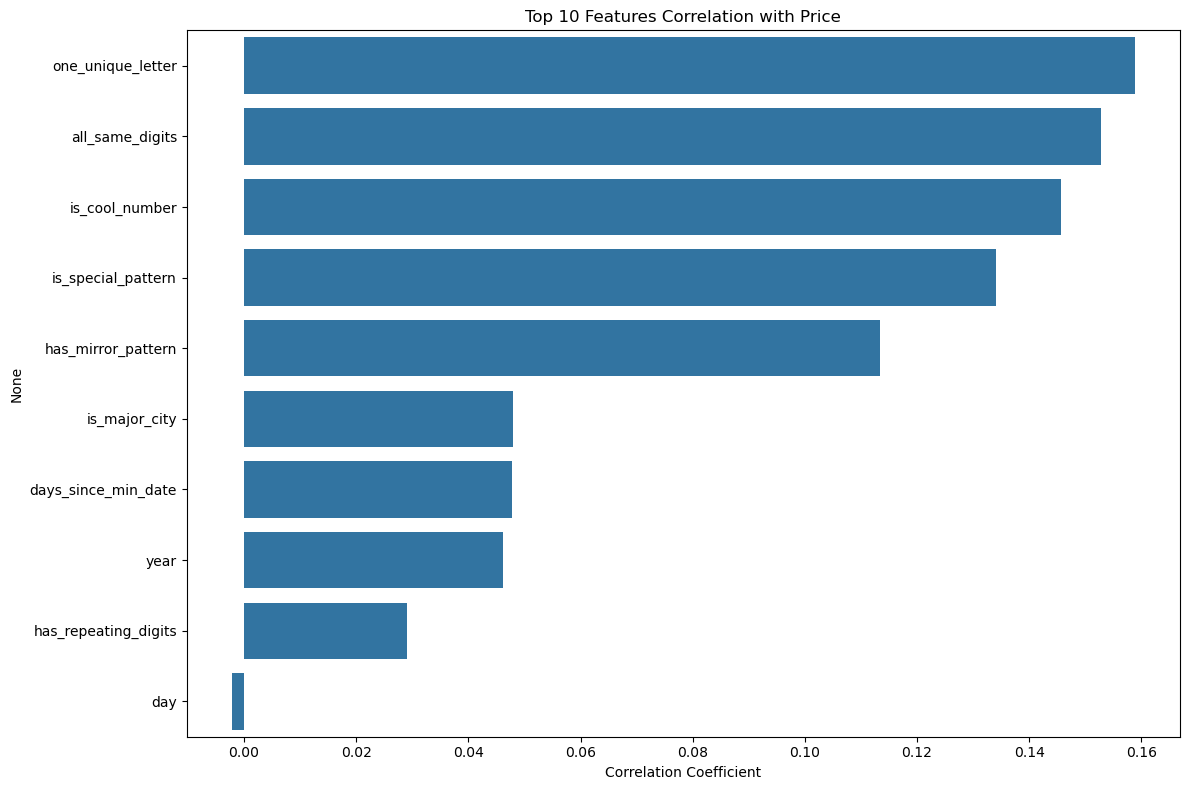

In [ ]:
def prepare_data(df):
    
    data = df.copy()
    
   
    data['date'] = pd.to_datetime(data['date'])
    
    
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    min_date = pd.to_datetime('2021-02-17')
    data['days_since_min_date'] = (data['date'] - min_date).dt.days

    
    
    data['letters'] = data['plate'].apply(lambda x: ''.join([c for c in x if c.isalpha()]))
    data['digits'] = data['plate'].apply(lambda x: ''.join([c for c in x if c.isdigit()]))
    
    
    data['region_code'] = data['plate'].str.extract(r'([0-9]{2,3})$')
    
   
    data['has_repeating_digits'] = data['digits'].apply(lambda x: len(set(x[:-2])) < len(x[:-2]))
    
   
    data['all_same_digits'] = data['digits'].apply(lambda x: len(set(x[:-2])) == 1 if len(x) > 2 else False)
    
    
    def is_sequence(s):
        if len(s) < 3:
            return False
        digits = [int(d) for d in s[:-2]]  
        return all(digits[i] + 1 == digits[i+1] for i in range(len(digits)-1))
    
    data['is_sequence'] = data['digits'].apply(is_sequence)
    
    
    data['is_special_pattern'] = data['digits'].apply(lambda x: x[:-2] in ['111', '222', '333', '444', '555', '666', '777', '888', '999'])
    
    
    gov_codes_str = {str(k): v for k, v in GOVERNMENT_CODES.items()}
    data['is_government'] = data['plate'].apply(lambda x: any(gov_code in x for gov_code in gov_codes_str.keys() if isinstance(gov_code, str)))
    
   
    data['is_major_city'] = data['region_code'].apply(lambda x: x in ['77', '97', '99', '177', '197', '199', '777', '797', '799', '78', '98', '178', '198', '778', '798'] if pd.notna(x) else False)
    
   
    data['plate_length'] = data['plate'].apply(len)
    
   
    def has_mirror_pattern(plate):
        letters = [c for c in plate if c.isalpha()]
        return len(letters) >= 2 and letters[0] == letters[-1]
    
    data['has_mirror_pattern'] = data['plate'].apply(has_mirror_pattern)
    
    
    min_date = pd.to_datetime('2021-02-17')
    data['days_since_min_date'] = (data['date'] - min_date).dt.days
    
   
    data['one_unique_letter'] = data['letters'].apply(lambda x: len(set(x)) == 1)
    
   
    data['is_cool_number'] = data['digits'].apply(lambda x: x[:-2] in ['001', '007', '777', '999', '888', '555', '100', '200', '300', '500', '600', '700', '800', '900'])
    
    return data


train_processed = prepare_data(train_df)
test_processed = prepare_data(test_df)


numerical_cols = ['year', 'month', 'day', 'dayofweek', 'is_weekend', 'has_repeating_digits', 
                  'all_same_digits', 'is_sequence', 'is_special_pattern', 'is_government', 
                  'is_major_city', 'plate_length', 'has_mirror_pattern', 'days_since_min_date',
                  'one_unique_letter', 'is_cool_number']

correlation = train_processed[numerical_cols + ['price']].corr()['price'].sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=correlation.values[1:11], y=correlation.index[1:11])
plt.title('Top 10 Features Correlation with Price')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


In [14]:
def prepare_data(df):
   
    data = df.copy()
    
    
    data['date'] = pd.to_datetime(data['date'])
    
    
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['is_weekend'] = data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    
    data['letters'] = data['plate'].apply(lambda x: ''.join([c for c in x if c.isalpha()]))
    data['digits'] = data['plate'].apply(lambda x: ''.join([c for c in x if c.isdigit()]))
    
   
    data['region_code'] = data['plate'].str.extract(r'([0-9]{2,3})$')
    
    
    data['has_repeating_digits'] = data['digits'].apply(lambda x: len(set(x[:-2])) < len(x[:-2]) if len(x) > 2 else False)
    
    
    data['all_same_digits'] = data['digits'].apply(lambda x: len(set(x[:-2])) == 1 and len(x) > 2)
    
   
    def is_sequence(s):
        if len(s) < 3:
            return False
        digits = [int(d) for d in s[:-2]] 
        return all(digits[i] + 1 == digits[i+1] for i in range(len(digits)-1))
    
    data['is_sequence'] = data['digits'].apply(is_sequence)
    
    
    data['is_special_pattern'] = data['digits'].apply(lambda x: x[:-2] in ['111', '222', '333', '444', '555', '666', '777', '888', '999'] if len(x) > 2 else False)
    
   
    data['all_same_letters'] = data['letters'].apply(lambda x: len(set(x)) == 1 and len(x) > 0)
    
  
    data['is_major_city'] = data['region_code'].apply(lambda x: x in ['77', '97', '99', '177', '197', '199', '777', '797', '799', '78', '98', '178', '198', '778', '798'] if pd.notna(x) else False)
    
    
    data['plate_length'] = data['plate'].apply(len)
    
    
    def has_mirror_pattern(plate):
        letters = [c for c in plate if c.isalpha()]
        return len(letters) >= 2 and letters[0] == letters[-1]
    
    data['has_mirror_pattern'] = data['plate'].apply(has_mirror_pattern)
    
    
    min_date = pd.to_datetime('2021-02-17')
    data['days_since_min_date'] = (data['date'] - min_date).dt.days
    
    
    data['one_unique_letter'] = data['letters'].apply(lambda x: len(set(x)) == 1 and len(x) > 0)
    
   
    data['is_cool_number'] = data['digits'].apply(lambda x: x[:-2] in ['001', '007', '777', '999', '888', '555', '100', '200', '300', '500', '600', '700', '800', '900'] if len(x) > 2 else False)
    
  
    data['first_letter'] = data['letters'].apply(lambda x: x[0] if len(x) > 0 else '')
    data['second_letter'] = data['letters'].apply(lambda x: x[1] if len(x) > 1 else '')
    data['third_letter'] = data['letters'].apply(lambda x: x[2] if len(x) > 2 else '')
    
  
    data['first_digit'] = data['digits'].apply(lambda x: x[0] if len(x) > 2 else '')
    data['second_digit'] = data['digits'].apply(lambda x: x[1] if len(x) > 3 else '')
    data['third_digit'] = data['digits'].apply(lambda x: x[2] if len(x) > 4 else '')
    
    
    data['letter_pattern'] = data['letters'].apply(lambda x: ''.join(sorted(set(x))))
    data['digit_pattern'] = data['digits'].apply(lambda x: ''.join(sorted(set(x[:-2]))) if len(x) > 2 else '')
    
    return data


train_processed = prepare_data(train_df)
test_processed = prepare_data(test_df)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


categorical_features = ['first_letter', 'second_letter', 'third_letter', 
                        'first_digit', 'second_digit', 'third_digit',
                        'region_code', 'letter_pattern', 'digit_pattern']

for feature in categorical_features:
    le = LabelEncoder()
    train_processed[feature] = le.fit_transform(train_processed[feature].astype(str))
    test_processed[feature] = le.transform(test_processed[feature].astype(str))

# Select features for modeling
features = ['year', 'month', 'day', 'dayofweek', 'is_weekend', 
            'has_repeating_digits', 'all_same_digits', 'is_sequence', 
            'is_special_pattern', 'is_major_city', 'plate_length', 
            'has_mirror_pattern', 'days_since_min_date', 'one_unique_letter', 
            'is_cool_number', 'all_same_letters', 'first_letter', 'second_letter', 
            'third_letter', 'first_digit', 'second_digit', 'third_digit',
            'region_code', 'letter_pattern', 'digit_pattern']

X = train_processed[features]
y = np.log1p(train_processed['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np


def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# xgb
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)
xgb_train_smape = smape(y_train, xgb_train_preds)
xgb_test_smape = smape(y_test, xgb_test_preds)
print(f"XGBoost - Train SMAPE: {xgb_train_smape:.2f}%")
print(f"XGBoost - Test SMAPE: {xgb_test_smape:.2f}%")

# 隨機森林
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

rf_train_smape = smape(y_train, rf_train_preds)
rf_test_smape = smape(y_test, rf_test_preds)
print(f"Random Forest - Train SMAPE: {rf_train_smape:.2f}%")
print(f"Random Forest - Test SMAPE: {rf_test_smape:.2f}%")

#gb
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_train_preds = gb_model.predict(X_train)
gb_test_preds = gb_model.predict(X_test)
gb_train_smape = smape(y_train, gb_train_preds)
gb_test_smape = smape(y_test, gb_test_preds)

print(f"Gradient Boosting - Train SMAPE: {gb_train_smape:.2f}%")
print(f"Gradient Boosting - Test SMAPE: {gb_test_smape:.2f}%")





XGBoost - Train SMAPE: 3.34%
XGBoost - Test SMAPE: 3.79%
Random Forest - Train SMAPE: 1.43%
Random Forest - Test SMAPE: 3.87%
Gradient Boosting - Train SMAPE: 4.75%
Gradient Boosting - Test SMAPE: 4.81%


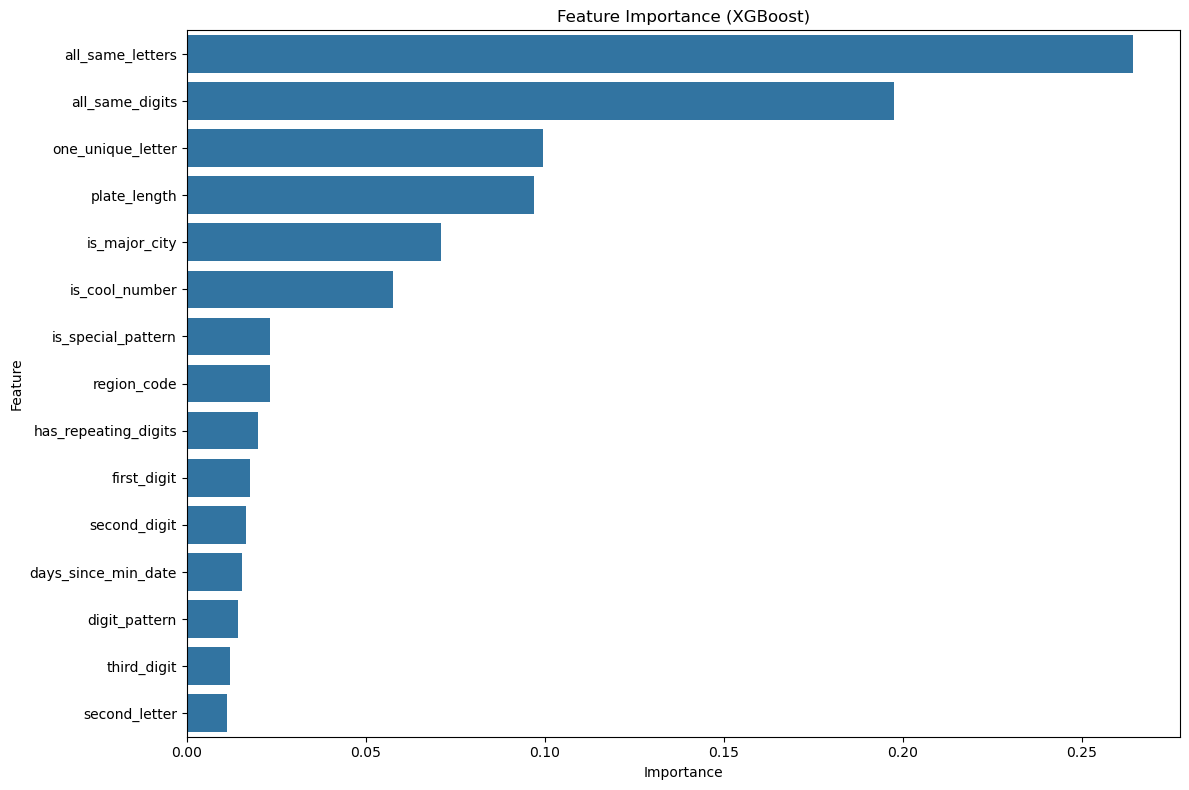

In [15]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance':xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)



plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()